In [891]:
# Importing the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from pathlib import Path
import os
#from tqdm.notebook import tqdm
from scipy.integrate import solve_ivp
from scipy.optimize import curve_fit
import numpy
import datetime
from datetime import timedelta

%matplotlib inline

In [3]:
#Coding up the Model Definition

# Susceptible equation
def dS_dt(S, I, R_t, T_inf):
    return -(R_t / T_inf) * I * S

# Exposed equation
def dE_dt(S, E, I, R_t, T_inf, T_inc):
    return (R_t / T_inf) * I * S - (T_inc**-1) * E

# Infected equation
def dI_dt(I, E, T_inc, T_inf):
    return (T_inc**-1) * E - (T_inf**-1) * I

# Recovered/Remove/deceased equation
def dR_dt(I, T_inf):
    return (T_inf**-1) * I


def SEIR_model(t, y, R_t, T_inf_t, T_inc,R_0,L,k,t_inf_0,t_inf_1):
    
    if callable(R_t):
        reproduction = R_t(t,R_0,L,k)
    else:
        reproduction = R_t
    
    if callable(T_inf_t):
        Inf_duartion = T_inf_t(t,t_inf_0,t_inf_1)
    else:
        Inf_duartion = T_inf_t
        
    S, E, I, R = y
    
    S_out = dS_dt(S, I, reproduction, Inf_duartion)
    E_out = dE_dt(S, E, I, reproduction, Inf_duartion, T_inc)
    I_out = dI_dt(I, E, T_inc, Inf_duartion)
    R_out = dR_dt(I, Inf_duartion)
    
    return [S_out, E_out, I_out, R_out]

## Covid-19 Infection Curves for Countries and Projected End Dates 

T_50 :   Date by which daily cases fall to 50% of the projected daily cases peak

T_25 :   Date by which daily cases fall to 25% of the projected daily cases peak

T_10 :   Date by which daily cases fall to 10% of the projected daily cases peak

T_97.5 : Date by which total cases reach 97.5% of the projected total case

In [ ]:
#Loading the  i/p data
df_All_Cases  = pd.read_csv(r"C:\Covid19_SEIR\covid_19_clean_complete.csv")
df_Population  = pd.read_csv(r"C:\Covid19_SEIR\Country_Population.csv") 

In [591]:
# Time varying transmission rate

import math 
def time_varying_R(t,R_01,L_1,k_1): 
    return R_01 / (1 + (t/L_1)**k_1)


def time_varying_T(t,t_inf_0,t_inf_1):
    exponent = -t/(t_inf_1)
    if t<70:
        return t_inf_0 
    else:
        return t_inf_0*math.exp(exponent)

def time_varying_T2(t,t_inf_0,t_inf_1):
    exponent = -t/(t_inf_1)
    return t_inf_0*math.exp(exponent)  

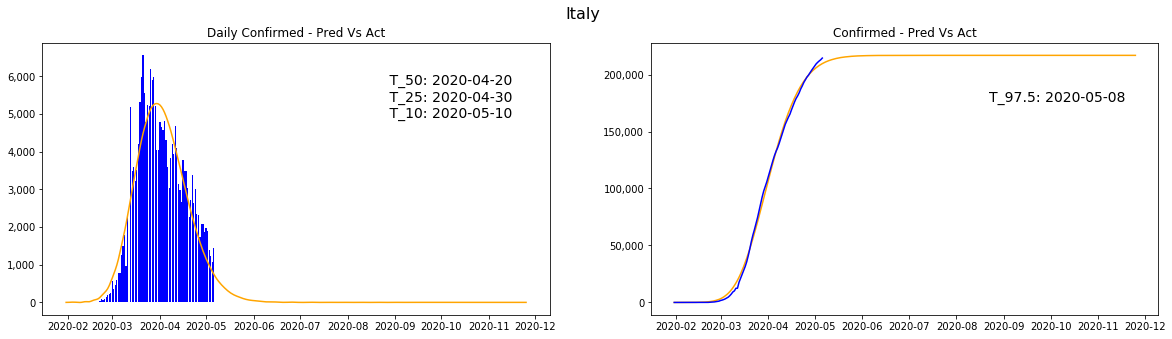

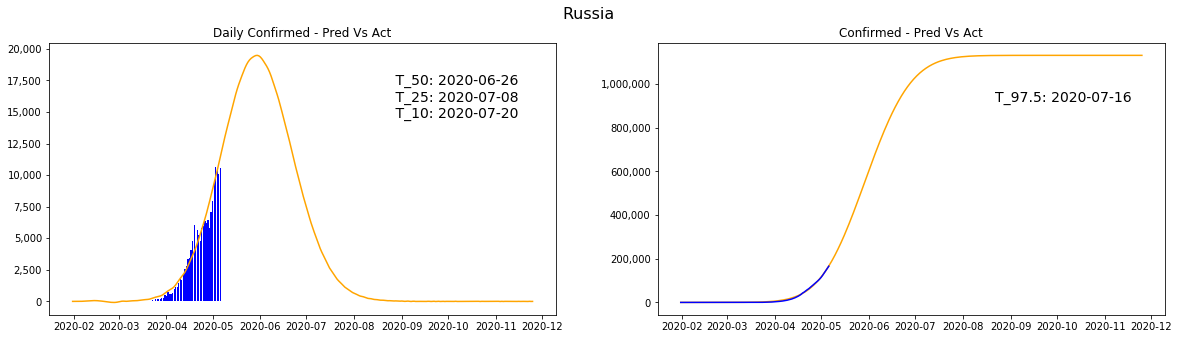

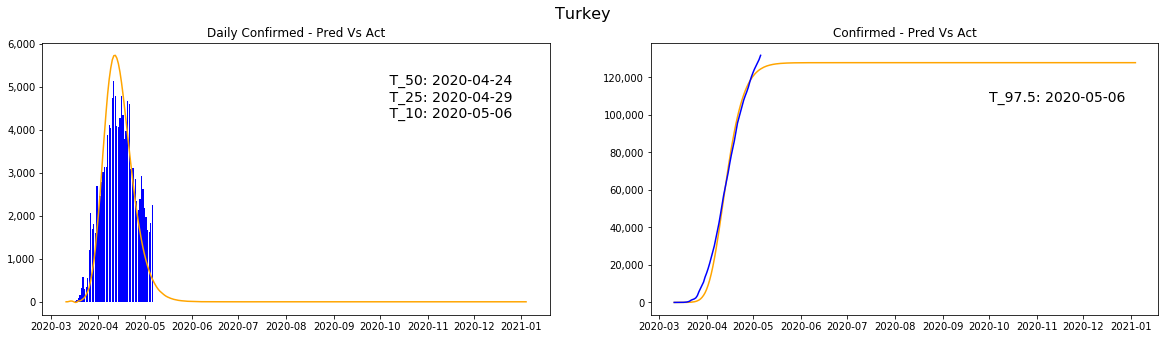

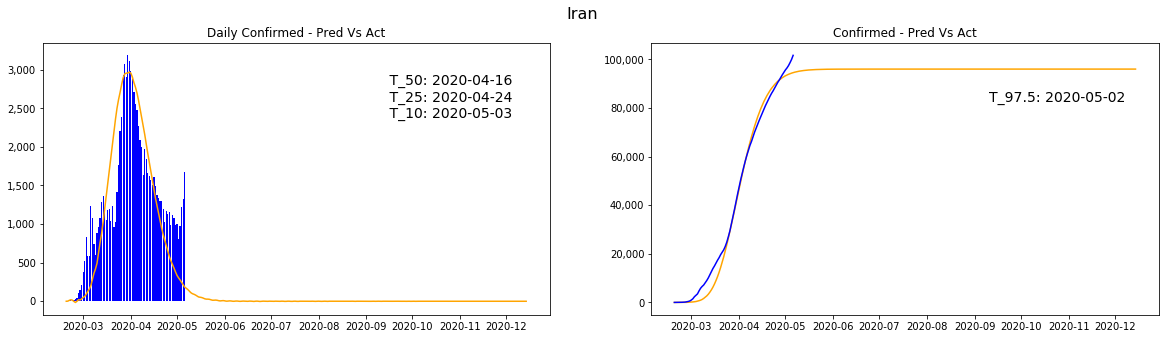

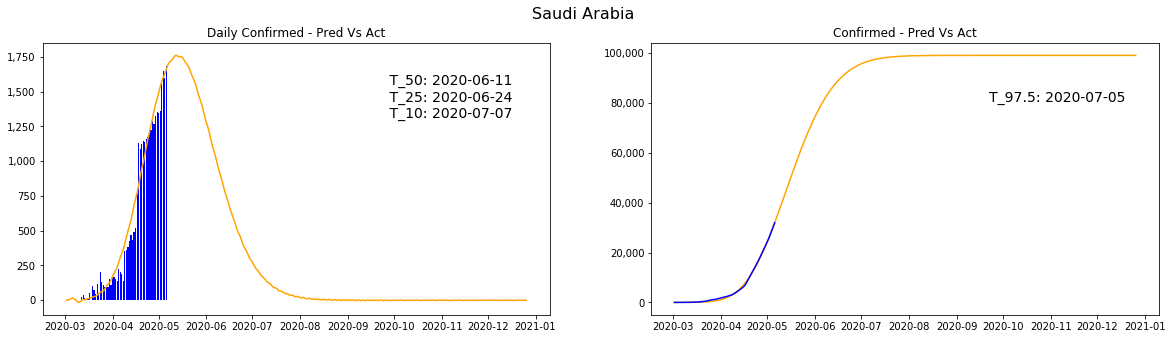

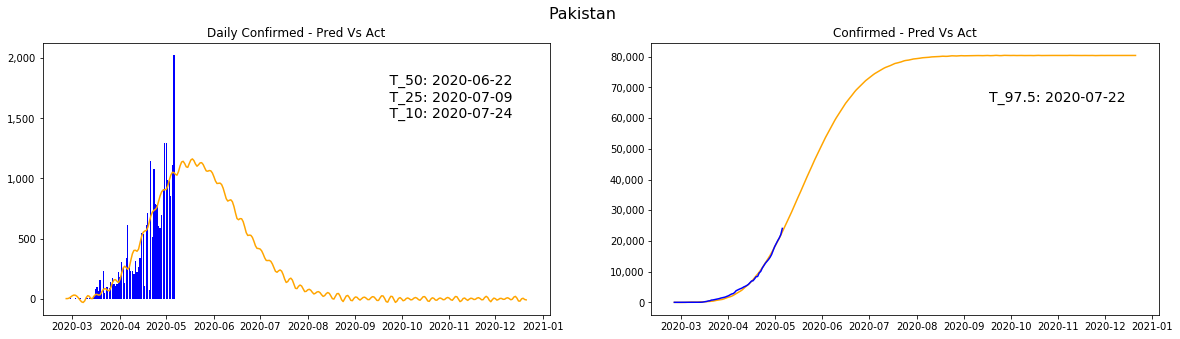

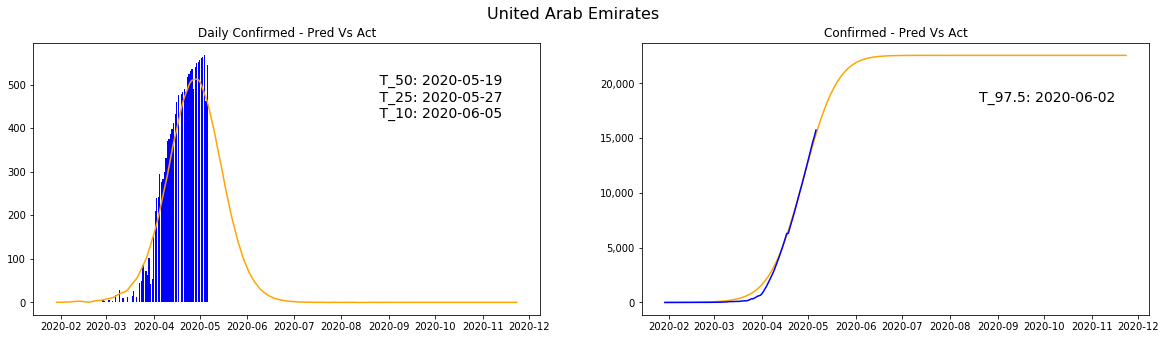

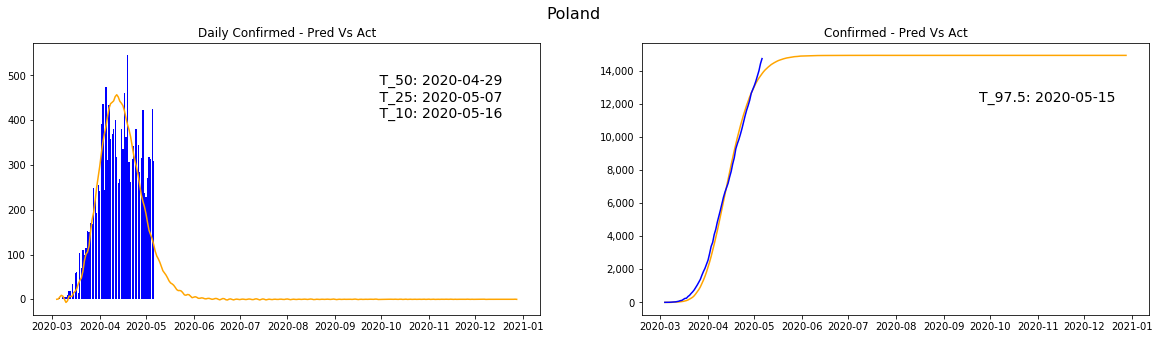

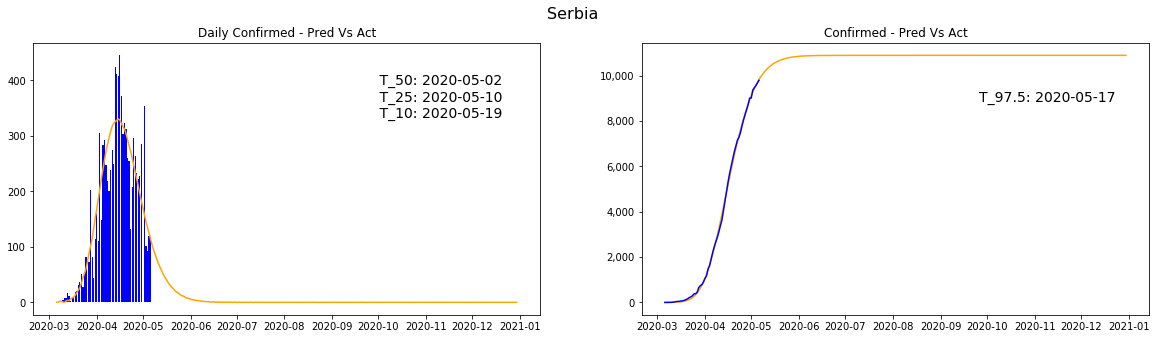

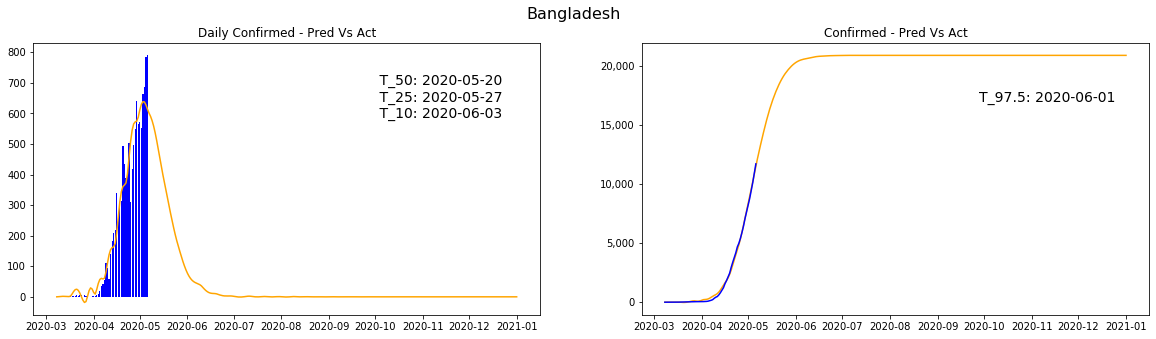

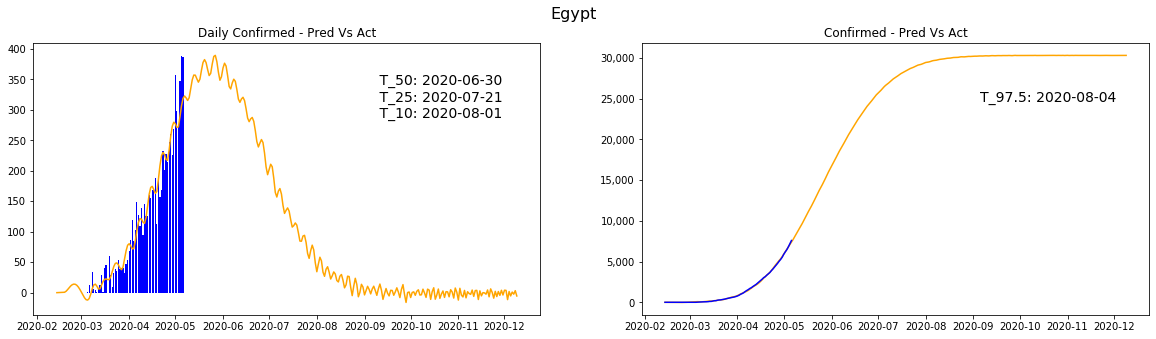

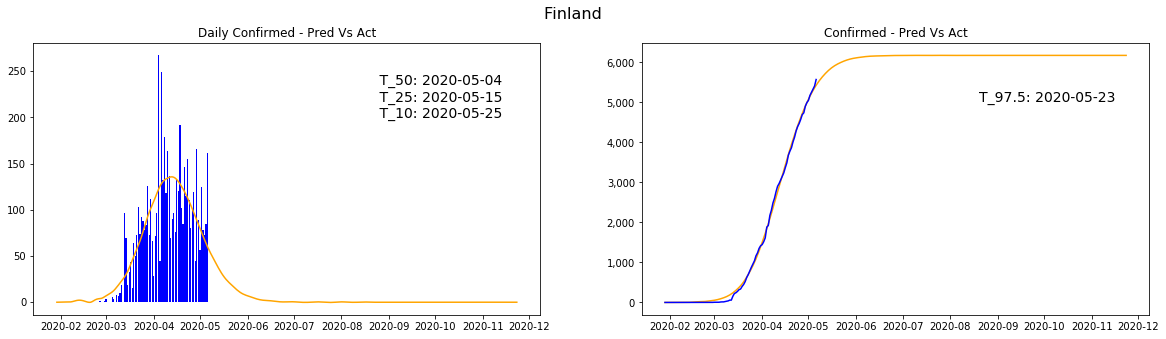

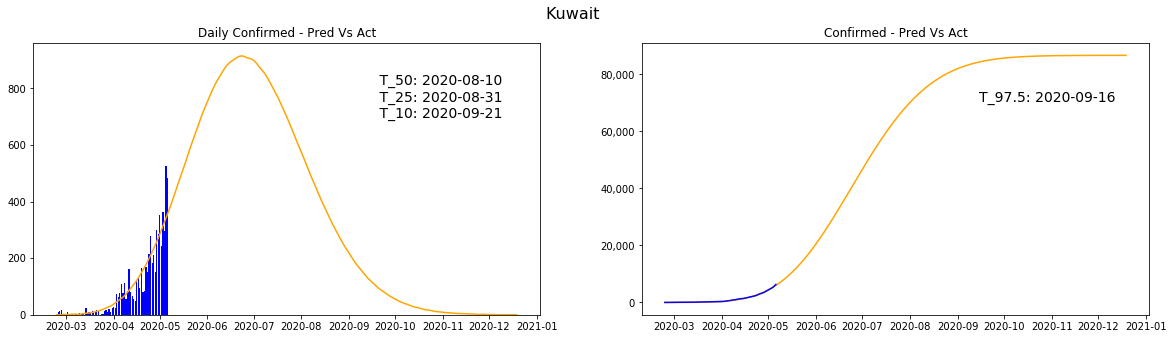

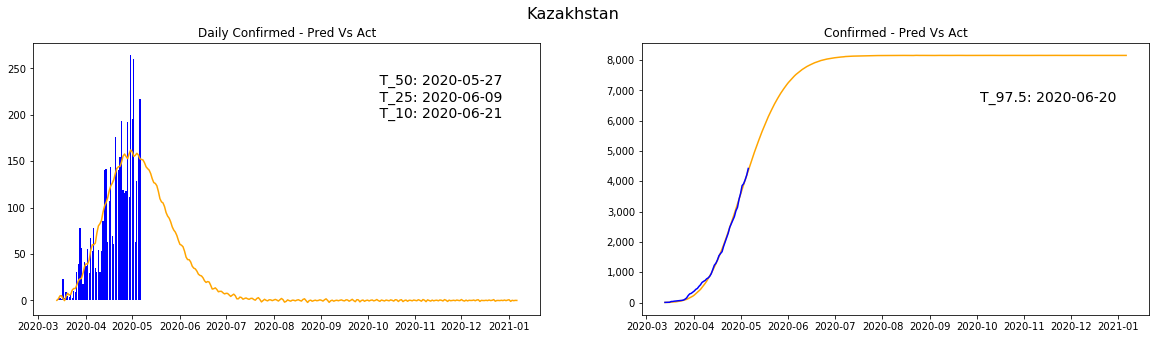

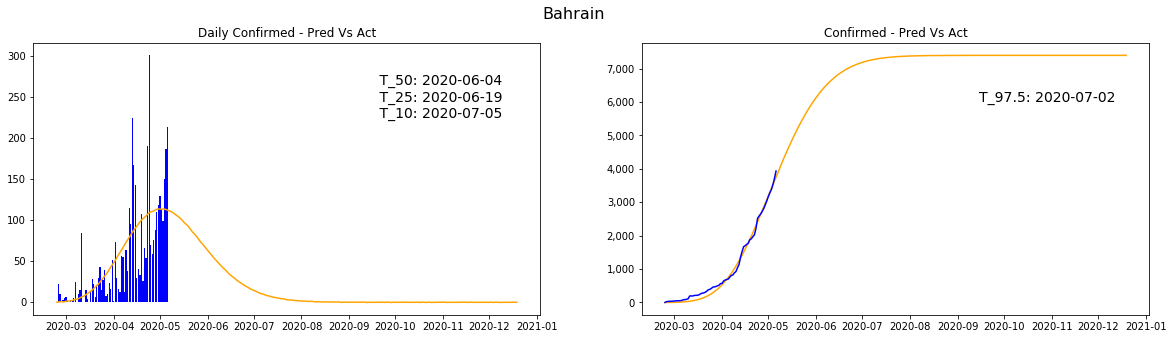

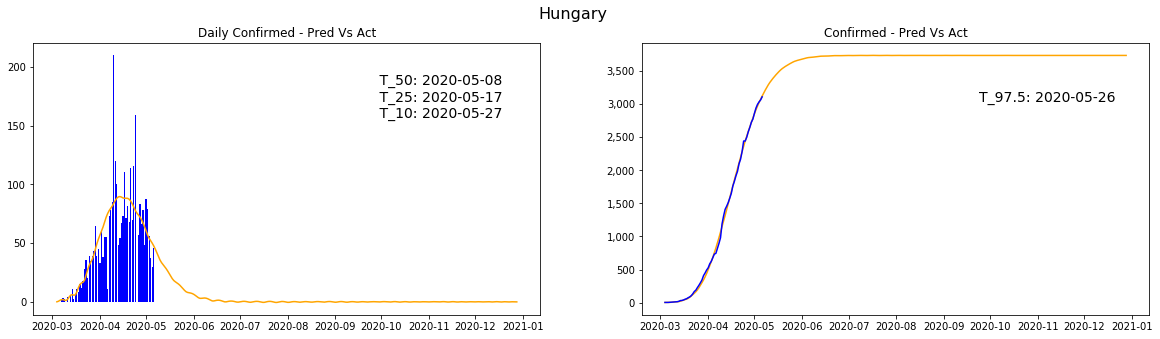

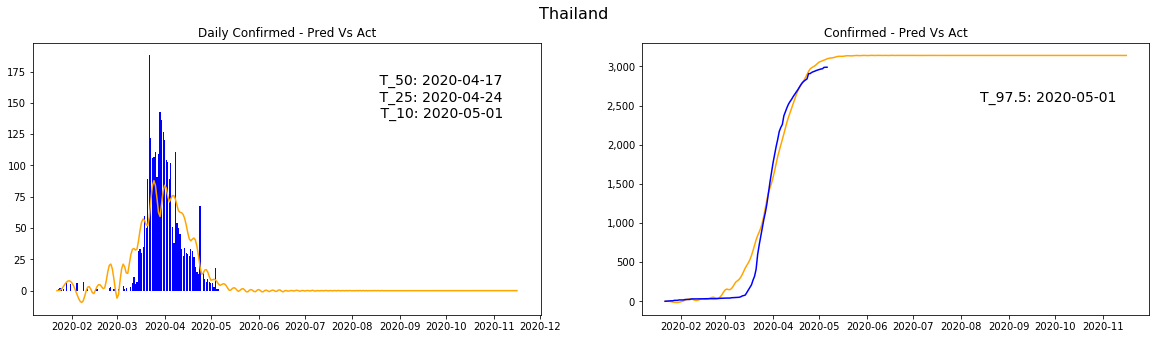

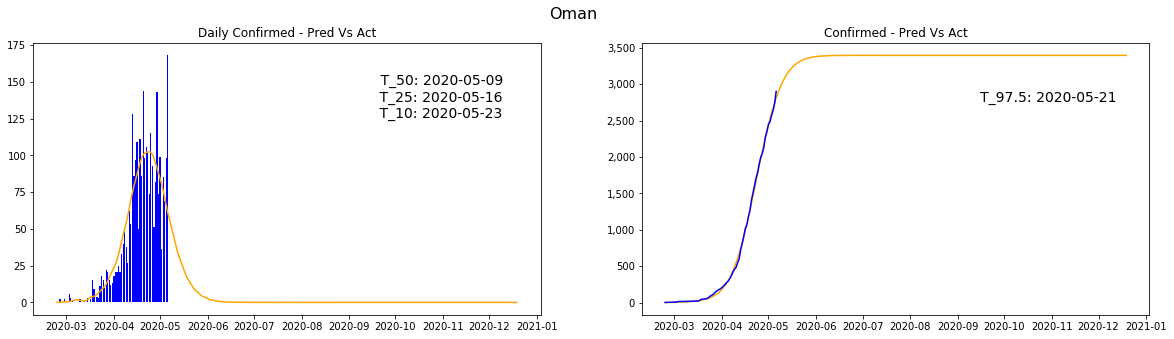

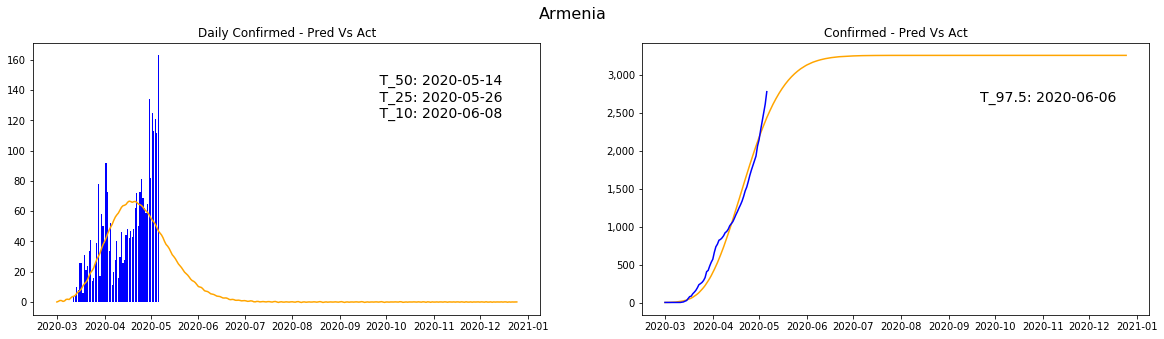

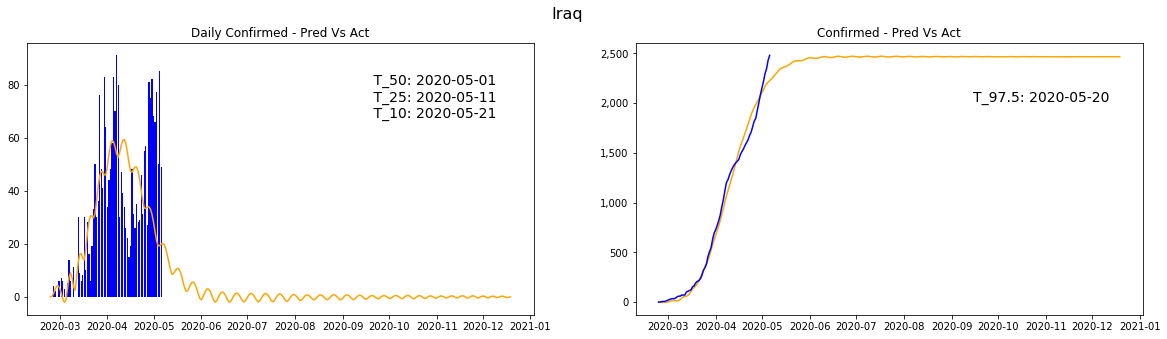

In [953]:
country_list = ['Italy','Russia','Turkey','Iran','Saudi Arabia','Pakistan','United Arab Emirates',
'Poland','Serbia','Bangladesh','Egypt','Finland','Kuwait','Kazakhstan',
'Bahrain','Hungary','Thailand','Oman','Armenia','Iraq','Uzbekistan','Croatia','Romania','Sri Lanka','Jordan',
'Azerbaijan','Bosnia and Herzegovina','Bulgaria','Afghanistan','India','North Macedonia','Slovenia','Slovakia','Djibouti',
'Kyrgyzstan','Lebanon','Sudan','Tanzania','Kenya','Montenegro','Ukraine',
'Uganda','South Sudan','Syria','Yemen','Czech','Nepal']

column_names =["Country","Snap_Date","T_50","T_25","T_10","T_97.5"]
Df_End_Dates = pd.DataFrame(columns =column_names )
Df_End_Dates

for country in country_list[:20]:
    df_Cases=df_All_Cases[df_All_Cases["Country/Region"]==country][["Country/Region","Date","Confirmed","Deaths","Recovered"]].groupby(["Country/Region","Date"]).sum().reset_index()
    df_Cases["Date"]=pd.to_datetime(df_Cases["Date"])
    df_Cases=df_Cases.sort_values("Date")
    df_Cases=df_Cases[df_Cases.Confirmed>0].reset_index(drop=True)
    df_final = df_Cases.merge(df_Population,left_on= "Country/Region",right_on ="Country")


#deriving the input data column for training

    xdata = np.arange(len(df_final.Date))
    xdata
#ydata = np.array(input_data.Active)
#ydata = np.array(input_data.Confirmed)
    ydata = np.array(df_final.Confirmed.diff().fillna(0))
    ydata2 = np.array(df_final.Confirmed)
    ydata



# wrapper to solve the model with population number function parameters

    T_inc = 5.5  # average incubation period
#T_inf = 3 # average infectious period
    n_infected =df_final.Confirmed[0]
    N= min(df_final.Population)
    s = (N - n_infected)/ N
    e = 0
    i = n_infected / N
    r = 0.
#SEIR_model(t, y, R_t, T_inf, T_inc,R_0,L,k)
    def solve_inf (t,R_fit, L_fit, k_fit,T_Inf_0_fit,T_Inf_1_fit):
        return solve_ivp(SEIR_model, [0, len(df_final.Date)], [s, e, i, r], 
                 args=(time_varying_R, time_varying_T2,T_inc,R_fit, L_fit, k_fit,T_Inf_0_fit,T_Inf_1_fit),
                 t_eval=t).y[1][:len(df_final.Date)]*N/T_inc 

    def solve_conf(t,R_fit, L_fit, k_fit,T_Inf_0_fit,T_Inf_1_fit):
        return solve_ivp(SEIR_model, [0, len(df_final.Date)], [s, e, i, r], 
                 args=(time_varying_R,time_varying_T2,T_inc,R_fit, L_fit, k_fit,T_Inf_0_fit,T_Inf_1_fit),
                 t_eval=t).y[2][:len(df_final.Date)]*N + solve_ivp(SEIR_model, [0, len(df_final.Date)], [s, e, i, r], 
                 args=(time_varying_R,time_varying_T2, T_inc,R_fit, L_fit, k_fit,T_Inf_0_fit,T_Inf_1_fit),
                 t_eval=t).y[3][:len(df_final.Date)]*N

    def combinedFunction(t,R_fit, L_fit, k_fit,T_Inf_0_fit,T_Inf_1_fit):
        return np.append(solve_inf (t,R_fit, L_fit, k_fit,T_Inf_0_fit,T_Inf_1_fit),solve_conf(t,R_fit, L_fit, k_fit,T_Inf_0_fit,T_Inf_1_fit))


    popt, pcov = curve_fit(combinedFunction, xdata ,np.append(ydata,ydata2),bounds=([1,20,1,2,30], [7, 80, 5,12,300]))
#popt, pcov = curve_fit(solve_conf, xdata,ydata2,bounds=([1,20,1,2,50], [7, 80, 5,12,250]))
    #print ('Optial Parm Values')
    #print(popt)
    #print("Population")
    #print(N)


    max_days = 300 
##SEIR_model(t, y, R_t, T_inf_t, T_inc,R_0,L,k,t_inf_0,t_inf_1)
    sol2 = solve_ivp(SEIR_model, [0, max_days], [s, e, i, r], 
                 args=(time_varying_R, time_varying_T2,T_inc,*popt),
                 t_eval=np.arange(max_days))
#plot_model_and_predict( N, sol2, N,title = 'SEIR Model (with intervention)')

#sol3 = solve_ivp(SEIR_model, [0, max_days], [s, e, i, r], 
                 #args=(time_varying_R, time_varying_T2,T_inc,*popt2),
                 #t_eval=np.arange(max_days))

#plot_model_and_predict( N, sol3, N,title = 'SEIR Model (with intervention)')

    Model_Forecast = pd.DataFrame({"Pred_Confirmed":sol2.y[2][:300]*N+sol2.y[3][:300]*N,"Pred_Daily_Cases":sol2.y[1][:300]*N/T_inc})

    Final_Full_Df=Model_Forecast.join (df_final, how ='left')
    Final_Full_Df['Day'] = Final_Full_Df.index
    Final_Full_Df['First_Date'] = min(Final_Full_Df.Date)
    Final_Full_Df['New_date']=pd.to_datetime(Final_Full_Df.First_Date) + pd.to_timedelta(Final_Full_Df.Day, unit="D")
    Final_Full_Df['Daily_Confirmed'] =Final_Full_Df.Confirmed.diff().fillna(0)

   # print("First Date")
    #print(min(Final_Full_Df.Date))

   
    
    
    #max_daily = max([max(Final_Full_Df.Pred_Daily_Cases),max(Final_Full_Df.Daily_Confirmed)])
    max_daily_pred = max(Final_Full_Df.Pred_Daily_Cases)
    snap_date = max(df_final.Date)
    Peak_day = Final_Full_Df.Pred_Daily_Cases.idxmax()
    Daily_50_Pc_max_date = min(Final_Full_Df[(Final_Full_Df.Pred_Daily_Cases<0.5*max_daily_pred)&(Final_Full_Df.Day>=Peak_day)].New_date)
    Daily_25_Pc_max_date = min(Final_Full_Df[(Final_Full_Df.Pred_Daily_Cases<0.25*max_daily_pred)&(Final_Full_Df.Day>=Peak_day)].New_date)
    Daily_10_Pc_max_date = min(Final_Full_Df[(Final_Full_Df.Pred_Daily_Cases<0.10*max_daily_pred)&(Final_Full_Df.Day>=Peak_day)].New_date)
    approx_end_date=max(Final_Full_Df[Final_Full_Df.Pred_Confirmed<0.975*max(Final_Full_Df.Pred_Confirmed)].New_date)

    x  = np.array(Final_Full_Df.New_date)
    y1 = np.array(Final_Full_Df.Pred_Daily_Cases)
    y2 = np.array(Final_Full_Df.Daily_Confirmed)
    y3 = np.array(Final_Full_Df.Pred_Confirmed)
    y4 = np.array(Final_Full_Df.Confirmed)
    
    
    fig, ax = plt.subplots(1, 2, figsize=(20,5))
    ax[0].plot(x,y1,label='Pred Daily Cases', color='orange')
    ax[0].bar(x,y2,label='Act Daily Cases', color='b')
    ax[0].set_title('Daily Confirmed - Pred Vs Act')
    ax[0].get_yaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    

    #ax1 = plt.gca()
    ax[0].text(0.8, 0.8," T_50: {}\n T_25: {}\n T_10: {}".format(Daily_50_Pc_max_date.strftime('%Y-%m-%d') ,Daily_25_Pc_max_date.strftime('%Y-%m-%d'),Daily_10_Pc_max_date.strftime('%Y-%m-%d')),  ha = 'center', va = 'center', transform=ax[0].transAxes,fontsize =14)

    ax[1].plot(x,y3,label='Pred Confirmed', color='orange')
    ax[1].plot(x,y4,label='Act Confirmed', color='b')
    ax[1].set_title('Confirmed - Pred Vs Act')
    ax[1].get_yaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    ax[1].text(0.8, 0.8,"T_97.5: {}".format(approx_end_date.strftime('%Y-%m-%d')),  ha = 'center', va = 'center', transform=ax[1].transAxes,fontsize =14)

    
    plt.suptitle(country, fontsize=16)
    lst_dict =[]
    vals = [country, snap_date, Daily_50_Pc_max_date,Daily_25_Pc_max_date,Daily_10_Pc_max_date,approx_end_date]
    lst_dict.append(dict(zip(column_names, vals)))
    Df_End_Dates = Df_End_Dates.append(lst_dict)
output_csv = Df_End_Dates.to_csv (r'C:\Covid19_SEIR\Dates_0.csv', header=True)

In [492]:
spread = pd.DataFrame({"Confirmed":sol2.y[2][:200]*N+sol2.y[3][:200]*N,"Daily Cases":sol2.y[1][:200]*N/5.5})
output_csv = spread.to_csv (r'C:\Covid19_SEIR\SK_Output3.csv', header=True)

In [955]:
%%html
<style>
div.input {
    display:none;
}
</style>